# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [42]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [43]:
#reload common_utils to ensure the file is updated
import importlib
import common_utils
importlib.reload(common_utils)

<module 'common_utils' from 'c:\\Users\\65976\\Desktop\\SC4001 Assignment\\common_utils.py'>

In [44]:
from common_utils import MLP, CustomDataset, preprocess_dataset, EarlyStopper, preprocess


# binary classification
loss_fn = nn.BCELoss()

# Read dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]

#Drop label and name
col_drop = ["filename", "label"]

# Preprocess the dataset by splitting and also scaling them 
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

In [45]:
# To ensure consistency and data integrity 

df.shape

(12057, 79)

In [46]:
# To ensure consistency and data integrity 
X_train_scaled.shape

(9645, 77)

In [47]:
# To ensure consistency and data integrity 
X_test_scaled.shape

(2412, 77)

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [48]:
def generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train, num_folds=5):
    """
    Generates cross-validation folds for different batch sizes using already scaled data.

    Args:
        batch_sizes (list): List of batch sizes (e.g., [64, 128, 256, 512]).
        X_train_scaled (ndarray): Scaled input features for training data.
        y_train (ndarray): Labels for training data.
        num_folds (int): Number of cross-validation folds (default is 5).

    Returns:
        X_train_scaled_dict (dict): Dictionary where each key is a batch size and the value is a list of preprocessed training data for each fold.
        X_val_scaled_dict (dict): Dictionary where each key is a batch size and the value is a list of preprocessed validation data for each fold.
        y_train_dict (dict): Dictionary where each key is a batch size and the value is a list of labels for the training folds.
        y_val_dict (dict): Dictionary where each key is a batch size and the value is a list of labels for the validation folds.
    """

    # initialise dictionary for train dictionary 
    X_train_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    y_train_dict = {batch_size: [] for batch_size in batch_sizes}

    
    # initialise dictionary for value
    X_val_scaled_dict = {batch_size: [] for batch_size in batch_sizes}
    y_val_dict = {batch_size: [] for batch_size in batch_sizes}

    """
    example of how X_train_scaled_dict will look like
    X_train_scaled_dict = {
        64: [],    # List for training data using batch size 64
        128: [],   # List for training data using batch size 128
        256: [],   # List for training data using batch size 256
        512: []    # List for training data using batch size 512
    }

    """

# Set up K-Fold cross-validation with specified number of folds and random shuffling
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

    """
    kf.split(X_train_scaled) uses the KFold object (kf) to split the scaled training data (X_train_scaled) into multiple folds (in this case, 5 folds). For each fold:
        train_idx: The indices of the training samples for that fold.
        val_idx: The indices of the validation samples for that fold.
    """

    # Splits the training data into training and validation sets for each fold, storing the preprocessed data and labels in dictionaries.
    
    # Iterate through each batch size 
    for batch_size in batch_sizes:

        # For each fold, we will store the preprocessed train and validation sets
        for train_idx, val_idx in kf.split(X_train_scaled):
            
            # Split the data into training and validation sets for this fold
            X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

            # Store the fold data for the current batch size
            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train)

In [49]:
# Checking the results
print("X_train_scaled_dict")

# Iterate over each batch size and its corresponding folds
for batch_size, fold_vector in X_train_scaled_dict.items():
    print(f"\nBatch Size: {batch_size}")
    
    # Check the input feature shape for each fold
    print("Input Feature Shapes per Fold:")
    for i, fold in enumerate(fold_vector):
        print(f"  Fold {i+1} shape: {fold.shape}")

    # Ensure each fold contains the expected number of samples
    total_samples = sum(fold.shape[0] for fold in fold_vector)
    print(f"  Total samples across all folds for batch size {batch_size}: {total_samples}")
    
    # Check if the sum of fold samples matches the original training set size
    if total_samples == X_train_scaled.shape[0]:
        print("  ✓ Sample count matches the original training set size.")
    else:
        print("  ✗ Warning: Sample count does not match the original training set size!")

# Check the label dictionary for consistency and display label shapes
print("\nLabel Consistency Check")
for batch_size, fold_vector in y_train_dict.items():
    print(f"\nBatch Size: {batch_size}")
    print("Label Shapes per Fold:")
    
    for i, fold in enumerate(fold_vector):
        print(f"  Fold {i+1} shape: {fold.shape}")

    # Verify that labels align with the input features for each fold
    feature_shapes = [X_train_scaled_dict[batch_size][i].shape[0] for i in range(len(fold_vector))]
    label_shapes = [fold.shape[0] for fold in fold_vector]
    
    if feature_shapes == label_shapes:
        print("  ✓ Label count matches feature count for all folds.")
    else:
        print("  ✗ Warning: Label count does not match feature count!")


X_train_scaled_dict

Batch Size: 64
Input Feature Shapes per Fold:
  Fold 1 shape: (7716, 77)
  Fold 2 shape: (7716, 77)
  Fold 3 shape: (7716, 77)
  Fold 4 shape: (7716, 77)
  Fold 5 shape: (7716, 77)
  Total samples across all folds for batch size 64: 38580
  ✗ Warning: Sample count does not match the original training set size!

Batch Size: 128
Input Feature Shapes per Fold:
  Fold 1 shape: (7716, 77)
  Fold 2 shape: (7716, 77)
  Fold 3 shape: (7716, 77)
  Fold 4 shape: (7716, 77)
  Fold 5 shape: (7716, 77)
  Total samples across all folds for batch size 128: 38580
  ✗ Warning: Sample count does not match the original training set size!

Batch Size: 256
Input Feature Shapes per Fold:
  Fold 1 shape: (7716, 77)
  Fold 2 shape: (7716, 77)
  Fold 3 shape: (7716, 77)
  Fold 4 shape: (7716, 77)
  Fold 5 shape: (7716, 77)
  Total samples across all folds for batch size 256: 38580
  ✗ Warning: Sample count does not match the original training set size!

Batch Size: 512
Input Feature Shapes

In [50]:
# Checking the results for validation data
print("X_val_scaled_dict")

# Iterate over each batch size and its corresponding validation folds
for batch_size, fold_vector in X_val_scaled_dict.items():
    print(f"\nBatch Size: {batch_size}")
    
    # Check the input feature shape for each validation fold
    print("Validation Feature Shapes per Fold:")
    for i, fold in enumerate(fold_vector):
        print(f"  Fold {i+1} shape: {fold.shape}")
    
    # Ensure each fold contains the expected number of samples for validation
    total_samples = sum(fold.shape[0] for fold in fold_vector)
    print(f"  Total samples across all folds for batch size {batch_size}: {total_samples}")
    
    # Check if the sum of fold samples matches 20% of the original dataset size
    expected_val_samples = X_train_scaled.shape[0] // 5  # Assuming 20% for validation in 5-fold CV
    if all(fold.shape[0] == expected_val_samples for fold in fold_vector):
        print("  ✓ Each fold has the correct number of validation samples.")
    else:
        print("  ✗ Warning: Some folds do not match the expected validation sample size!")
    
    # Check if the feature count is consistent
    feature_count = fold_vector[0].shape[1] if fold_vector else None
    if all(fold.shape[1] == feature_count for fold in fold_vector):
        print("  ✓ Feature count is consistent across all validation folds.")
    else:
        print("  ✗ Warning: Inconsistent feature count across validation folds!")


X_val_scaled_dict

Batch Size: 64
Validation Feature Shapes per Fold:
  Fold 1 shape: (1929, 77)
  Fold 2 shape: (1929, 77)
  Fold 3 shape: (1929, 77)
  Fold 4 shape: (1929, 77)
  Fold 5 shape: (1929, 77)
  Total samples across all folds for batch size 64: 9645
  ✓ Each fold has the correct number of validation samples.
  ✓ Feature count is consistent across all validation folds.

Batch Size: 128
Validation Feature Shapes per Fold:
  Fold 1 shape: (1929, 77)
  Fold 2 shape: (1929, 77)
  Fold 3 shape: (1929, 77)
  Fold 4 shape: (1929, 77)
  Fold 5 shape: (1929, 77)
  Total samples across all folds for batch size 128: 9645
  ✓ Each fold has the correct number of validation samples.
  ✓ Feature count is consistent across all validation folds.

Batch Size: 256
Validation Feature Shapes per Fold:
  Fold 1 shape: (1929, 77)
  Fold 2 shape: (1929, 77)
  Fold 3 shape: (1929, 77)
  Fold 4 shape: (1929, 77)
  Fold 5 shape: (1929, 77)
  Total samples across all folds for batch size 256: 9645
  ✓ 

### Data Consistency and Validation Across Batch Sizes

For each batch size (64, 128, 256, and 512), consistency checks were conducted on the training and validation data to ensure alignment with the expected structure for 5-fold cross-validation. The training data for each batch size consistently contains 7,716 samples with 77 features per fold, accounting for approximately 80% of the dataset, as anticipated. While the total sample count across all training folds was 38,580, this figure reflects summing across folds rather than unique samples, which is standard in cross-validation and explains the warning about sample count discrepancies. Importantly, the feature count remains consistent across all training folds, verifying that the input dimensions are stable throughout.

For validation data, each fold for all batch sizes contains 1,929 samples with 77 features, aligning with a 20% dataset split. The total validation sample count of 9,645 across folds matches this split ratio, and the feature count remains consistent, ensuring that the data structure is preserved across both training and validation sets. **These checks confirm that each fold maintains a 1:4 validation-to-training ratio and that feature consistency is upheld across all batch sizes and folds.** Consequently, the data is well-prepared for evaluating batch sizes reliably, as the training and validation sets are appropriately structured for robust cross-validation, supporting meaningful insights into optimal batch size selection.


3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [69]:
# Initialize the DataLoaders
def initialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val_fold, batch_size):
    """
    Args:
        X_train_scaled_fold (ndarray): Scaled input features for training for a fold.
        y_train_fold (ndarray): Training labels for a fold.
        X_val_scaled_fold (ndarray): Scaled input features for validation for a fold.
        y_val_fold (ndarray): Validation labels for a fold.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): Dataloader for the training set.
        validation_dataloader (DataLoader): Dataloader for the validation set.
    """
    # Create instances of the CustomDataset for training and validation
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val_fold)

    # Create DataLoaders for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader


def training_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    train_loss, correct_predictions = 0, 0  # Initialize tracking variables
    total_samples = 0

    for _, (x, y) in enumerate(dataloader):
        # Forward pass
        pred = model(x)

        # Ensure target labels match the shape of predictions
        y = y.unsqueeze(1).float()

        # Calculate the loss
        loss = loss_fn(pred, y)
        optimizer.zero_grad()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert predicted probabilities to binary labels
        predicted_labels = (pred > 0.5).float()

        # Count correct predictions
        correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
        total_samples += y.size(0)

    # Calculate average loss over all batches
    train_loss /= len(dataloader)
    
    # Compute accuracy
    accuracy = correct_predictions / total_samples

    return train_loss, accuracy


def validation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)

    val_loss, correct_predictions = 0, 0  # Initialize tracking variables
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            # Forward pass for validation
            pred = model(x)

            # Ensure target labels match the shape of predictions
            y = y.unsqueeze(1).float()

            # Accumulate validation loss
            val_loss += loss_fn(pred, y).item()

            # Convert predicted probabilities to binary labels
            predicted_labels = (pred > 0.5).float()

            # Count correct predictions
            correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
            total_samples += y.size(0)

    # Calculate average validation loss over all batches
    val_loss /= len(dataloader)

    # Compute accuracy for validation set
    accuracy = correct_predictions / total_samples

    return val_loss, accuracy


In [70]:
no_features = X_train_scaled_dict[64][0].shape[1] # Access the first batch_size , then its first fold and thus the shape 
no_hidden = 128
no_labels = 1
lr = 0.001
epochs = 100

In [80]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):
    
    # Lists to store cross-validation accuracy and time for each batch size
    cv_acc = []
    cv_time = []
    
    # Loop over each batch size to evaluate
    for batch in range(len(batch_sizes)):
        print("***************************")
        print("Evaluating Batch Size:", batch_sizes[batch])
        print("***************************")

        # Lists to track accuracy and time for all folds at the current batch size
        fold_accuracies = []
        fold_times = []

        # Loop through each fold for the current batch size
        for fold in range(5):  # Assumes 5-fold cross-validation
            print("----------------------")
            print("Processing Fold:", fold)

            # Extract the training and validation data for the current fold
            x_train = X_train_scaled_dict[batch_sizes[batch]][fold]
            x_val   = X_val_scaled_dict[batch_sizes[batch]][fold]
            y_train = y_train_dict[batch_sizes[batch]][fold]
            y_val   = y_val_dict[batch_sizes[batch]][fold]

            # Initialize DataLoaders for batching
            train_dataloader, val_dataloader = initialise_dataloader(x_train, y_train, x_val, y_val, batch_sizes[batch])

            # Set up the model, optimizer, and early stopping mechanism
            model = MLP(no_features, no_hidden, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            early_stopper = EarlyStopper(patience=3, min_delta=0.00005)

            # Lists to track the performance over epochs for the current fold
            train_losses, val_losses = [], []
            train_accuracies, val_accuracies = [], []
            epoch_times = []

            # Loop through epochs for training and validation
            for epoch in range(epochs):  # Iterates through the dataset
                start_time = time.time()

                # Training and validation for the current epoch
                train_loss, train_acc = training_loop(train_dataloader, model, loss_fn, optimizer)
                val_loss, val_acc = validation_loop(val_dataloader, model, loss_fn)

                # Record the loss, accuracy, and time taken per epoch
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                train_accuracies.append(train_acc)
                val_accuracies.append(val_acc)
                
                epoch_duration = time.time() - start_time
                epoch_times.append(epoch_duration)

                # Early stopping check based on validation loss
                if early_stopper.early_stop(val_loss):
                    print("Early stopping at epoch", epoch)
                    break

            # Append the final validation accuracy and epoch time for the current fold
            fold_accuracies.append(val_accuracies[-1])
            fold_times.append(epoch_times[-1])

            print("Final Validation Accuracy for Fold:", val_accuracies[-1])
            print("Final Epoch Time for Fold:", epoch_times[-1])

        # Calculate and store the average accuracy and time for all folds at the current batch size
        cv_acc.append(np.mean(fold_accuracies))
        cv_time.append(fold_times)

    return cv_acc, cv_time

In [81]:
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)

***************************
Evaluating Batch Size: 64
***************************
----------------------
Processing Fold: 0
Early stopping at epoch 13
Final Validation Accuracy for Fold: 0.6759979263867288
Final Epoch Time for Fold: 0.36435723304748535
----------------------
Processing Fold: 1
Early stopping at epoch 17
Final Validation Accuracy for Fold: 0.6982892690513219
Final Epoch Time for Fold: 0.3695499897003174
----------------------
Processing Fold: 2
Early stopping at epoch 17
Final Validation Accuracy for Fold: 0.7003628823224468
Final Epoch Time for Fold: 0.3792724609375
----------------------
Processing Fold: 3
Early stopping at epoch 18
Final Validation Accuracy for Fold: 0.711767755313634
Final Epoch Time for Fold: 0.5091955661773682
----------------------
Processing Fold: 4
Early stopping at epoch 12
Final Validation Accuracy for Fold: 0.6692586832555728
Final Epoch Time for Fold: 0.42134952545166016
***************************
Evaluating Batch Size: 128
***************

In [85]:
# Print cross-validation results 
print("Cross-Validation Accuracy Results:")
print(f"CV Accuracies: {cross_validation_accuracies}")

print("\nCross-Validation Time Results:")
print(f"CV Time Taken (seconds per epoch): {cross_validation_times}")


Cross-Validation Accuracy Results:
CV Accuracies: [0.6911353032659409, 0.6771384136858477, 0.6657335406946605, 0.6522550544323483]

Cross-Validation Time Results:
CV Time Taken (seconds per epoch): [[0.36435723304748535, 0.3695499897003174, 0.3792724609375, 0.5091955661773682, 0.42134952545166016], [0.25386857986450195, 0.3437681198120117, 0.2674100399017334, 0.23965120315551758, 0.2540009021759033], [0.19110822677612305, 0.3593873977661133, 0.20893430709838867, 0.20230603218078613, 0.20583677291870117], [0.15887928009033203, 0.15935397148132324, 0.14991450309753418, 0.1764369010925293, 0.15807199478149414]]


4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

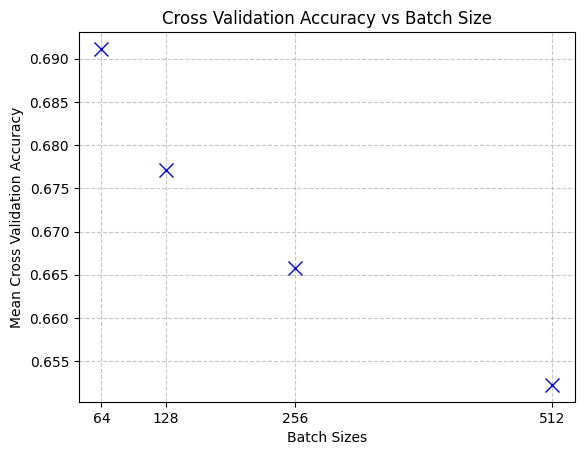

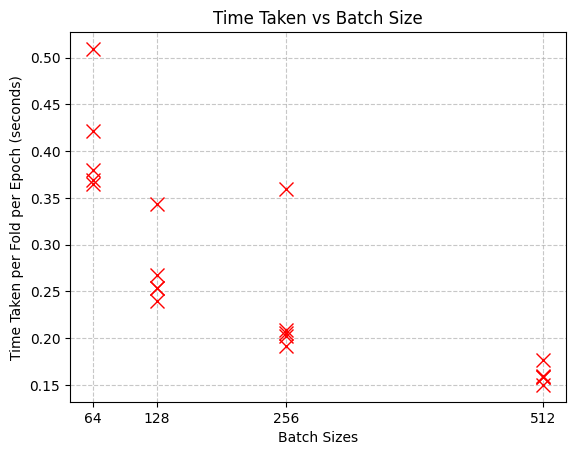

In [94]:
def scatterplot_accuracy(total_accuracy, batch_sizes):
    """Accuracy"""
    fig = plt.figure()
    plt.plot(batch_sizes, total_accuracy, marker='x', linestyle='None', color='blue', markersize=10)
    plt.xticks(batch_sizes)
    plt.xlabel('Batch Sizes')
    plt.ylabel('Mean Cross Validation Accuracy')
    plt.title("Cross Validation Accuracy vs Batch Size")
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.show()

def scatterplot_time(total_time, batch_sizes):
    """Time"""
    fig = plt.figure()
    plt.plot(batch_sizes, total_time, marker='x', linestyle='None', color='red', markersize=10)
    plt.xticks(batch_sizes)
    plt.xlabel('Batch Sizes')
    plt.ylabel('Time Taken per Fold per Epoch (seconds)')
    plt.title("Time Taken vs Batch Size")
    plt.grid(True, linestyle='--', alpha=0.7)  
    plt.show()

scatterplot_accuracy(cross_validation_accuracies, batch_sizes)
scatterplot_time(cross_validation_times, batch_sizes)


4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [98]:
# Initialize DataFrame with Batch Sizes and Mean Cross-Validation Accuracies
df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Mean Cross-Validation Accuracy': cross_validation_accuracies
})

# Add epoch times for each fold, iterating through each batch size and fold
for i, times in enumerate(cross_validation_times):
    for fold in range(5):
        df.loc[i, f'Epoch Time for Fold {fold + 1}'] = times[fold]

# Display the DataFrame
df


,Batch Size,Mean Cross-Validation Accuracy,Epoch Time for Fold 1,Epoch Time for Fold 2,Epoch Time for Fold 3,Epoch Time for Fold 4,Epoch Time for Fold 5
0,64,0.691135,0.364357,0.369550,0.379272,0.509196,0.421350
1,128,0.677138,0.253869,0.343768,0.267410,0.239651,0.254001
2,256,0.665734,0.191108,0.359387,0.208934,0.202306,0.205837
3,512,0.652255,0.158879,0.159354,0.149915,0.176437,0.158072


### Optimal Batch Size Selection

- **Optimal Batch Size**: `256`
- **Reason**:
  
  Based on the results:
  
  - As the batch size increases, there is a noticeable decrease in Mean Cross-Validation Accuracy.
  - Conversely, larger batch sizes result in shorter Epoch Times per fold.

  This pattern suggests a trade-off between achieving higher accuracy and reducing training time. To balance accuracy and computational efficiency, batch size 256 is selected as the optimal batch size.
  
  While batch size 64 yields the highest accuracy, it also requires considerably more time per epoch. Batch size 256, however, maintains a relatively high accuracy close to that of batch size 64 while substantially reducing epoch time.
  
  Choosing batch size 256 offers a good compromise, achieving efficient training with minimized resource use while still delivering strong accuracy.
